In [1]:
pip install lifelines

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from lifelines import CoxPHFitter, KaplanMeierFitter

In [4]:
#read the liquidity_challenge.csv

df = pd.read_csv('/content/liquidity_challenge.csv')


In [5]:
df.fillna(0, inplace=True)

Visualización de datos

In [85]:
df.head()

,property_id,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,...,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,069c4d09-1f4e-4451-bf9f-23130537bb37,1,96,apartment,120.0,2.5,2.0,-2.900370e+18,-7.946980e+18,1.0,...,1,0,0,0,0,0,0,0,0,0
1,0a4c5851-88ae-4d33-8fb7-f7d50ca85389,0,37,apartment,82.0,2.0,2.0,8.261010e+18,1.284470e+18,2.0,...,1,0,0,0,0,0,1,1,0,0
2,9d31a760-0ffd-44df-b77e-28fe6e1b019d,1,88,apartment,84.0,2.0,2.0,1.657070e+18,-3.834970e+18,1.0,...,0,0,0,0,0,0,0,0,0,0
3,fb141128-2a00-4117-929d-ca7ef507d2ab,1,58,apartment,92.0,2.0,2.0,-2.900370e+18,-7.946980e+18,0.0,...,1,0,0,0,0,0,1,0,0,0
4,b334cf18-5c23-4914-947a-d545c439845f,0,95,apartment,55.0,1.0,1.0,8.261010e+18,3.770270e+17,1.0,...,1,1,1,0,1,0,1,1,0,0


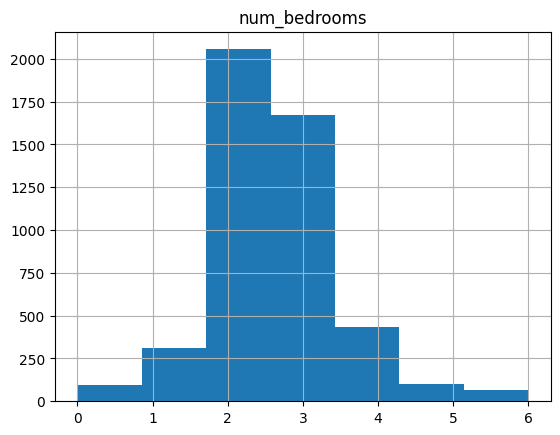

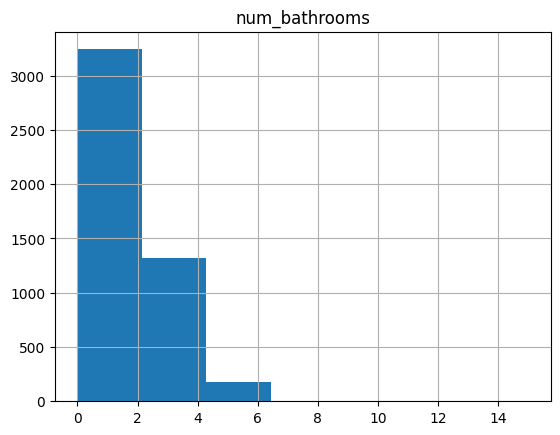

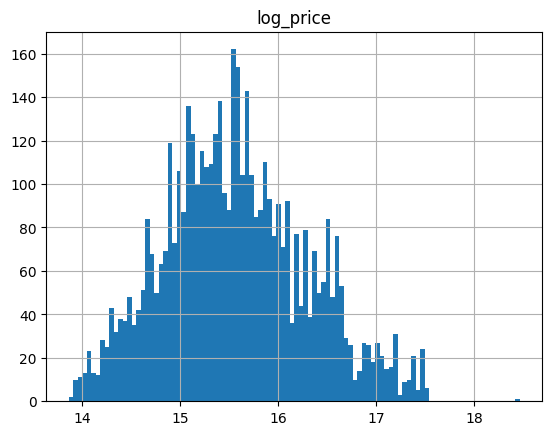

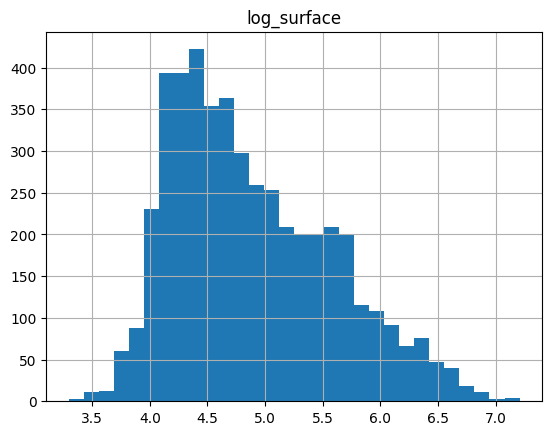

In [6]:
df2=df.copy()
df2['log_price'] = np.log(df2['last_price'])
df2['log_surface'] = np.log(df2['surface_total'])
# Assuming df is your DataFrame
columns = ['num_bedrooms', 'num_bathrooms', 'log_price', 'log_surface']
bins_list = [7, 7, 100, 30]

for column, bins in zip(columns, bins_list):
    df2[column].hist(bins=bins)
    plt.title(column)
    plt.show()


Comentario:log precio y log superficie estan mucho más normalmente distribuidas por lo que permitirán que el modelo no presente mucho sesgo ante los outliers. Esto viene del costo de la interpretabilidad sencilla.

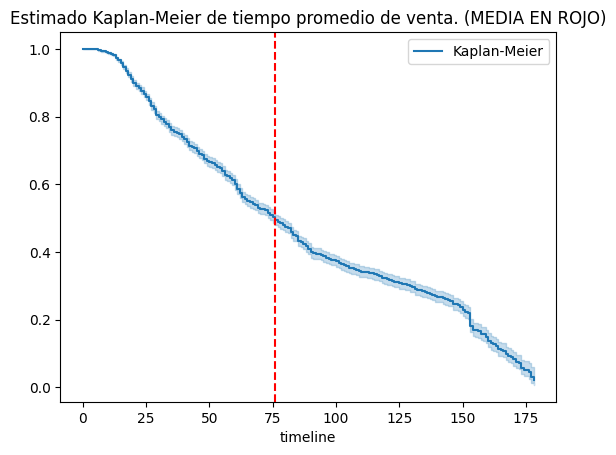

In [96]:
kmf = KaplanMeierFitter()
kmf.fit(df['time2event'], df['event'], label='Kaplan-Meier')
kmf.plot()
median_survival_time = kmf.median_survival_time_
plt.axvline(x=median_survival_time, color='red', linestyle='--')
plt.title('Estimado Kaplan-Meier de tiempo promedio de venta. (MEDIA EN ROJO)')
plt.show()


In [7]:
df2.keys()

Index(['property_id', 'event', 'time2event', 'property_type', 'surface_total',
       'num_bathrooms', 'num_bedrooms', 'marketplace_hash', 'seller_hash',
       'num_parking_lots', 'first_price', 'last_price', 'longitude',
       'latitude', 'views', 'num_marketplaces_property_at',
       'first_observed_date', 'last_observed_date', 'has_balcony',
       'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features',
       'has_pool', 'has_studio', 'has_surveillance', 'has_terrace',
       'has_visitors_parking', 'has_washing_area', 'log_price', 'log_surface'],
      dtype='object')

In [8]:
#codificando variables categoricas
df_enc = pd.get_dummies(df2[['event', 'time2event', 'property_type',
       'num_bathrooms', 'num_bedrooms', 'num_parking_lots', 'views',
       'num_marketplaces_property_at', 'has_balcony', 'has_elevator', 'has_garden', 'has_gym',
       'has_luxury_features', 'has_pool', 'has_studio', 'has_surveillance', 'has_terrace',
       'has_visitors_parking', 'has_washing_area', 'log_price', 'log_surface']],drop_first=1)

In [89]:
df_enc.head()

,event,time2event,num_bathrooms,num_bedrooms,num_parking_lots,views,num_marketplaces_property_at,has_balcony,has_elevator,has_garden,...,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area,log_price,log_surface,property_type_house
0,1,96,2.5,2.0,1.0,51,1,0,1,0,...,0,0,0,0,0,0,0,15.226498,4.787492,0
1,0,37,2.0,2.0,2.0,61,1,1,1,0,...,0,0,0,1,1,0,0,15.404746,4.406719,0
2,1,88,2.0,2.0,1.0,50,3,0,0,0,...,0,0,0,0,0,0,0,14.838931,4.430817,0
3,1,58,2.0,2.0,0.0,68,2,1,1,0,...,0,0,0,1,0,0,0,15.479437,4.521789,0
4,0,95,1.0,1.0,1.0,58,6,0,1,1,...,0,1,0,1,1,0,0,14.994166,4.007333,0


In [91]:
# modelo sin variables no significativas
cph = CoxPHFitter()
dff = df_enc.drop(["has_elevator","has_washing_area","has_garden","has_pool","log_surface","has_visitors_parking"],axis=1)
cph.fit(dff,duration_col= 'time2event', event_col = 'event')


<lifelines.CoxPHFitter: fitted with 4740 total observations, 1913 right-censored observations>

Resumen del modelo CPH

Recordar que la interpretación va de la siguiente forma: Un aumento de una unidad de {covariate} esta asociado con un cambio de ({exp(coef)}-1)*100% de Hazard.

Es decir en cada momento una propiedad con balcon tiene -6% de probabilidad de venderse que una propiedad sin balcon.

In [92]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
num_bathrooms,-0.038044,0.962670,0.026249,-0.089491,0.013402,0.914397,1.013492,0.0,-1.449389,1.472290e-01,2.763866
num_bedrooms,0.041997,1.042891,0.025627,-0.008231,0.092224,0.991803,1.096611,0.0,1.638771,1.012611e-01,3.303849
num_parking_lots,0.021114,1.021339,0.020375,-0.018821,0.061049,0.981355,1.062951,0.0,1.036258,3.000818e-01,1.736572
views,0.001075,1.001076,0.001008,-0.000900,0.003050,0.999101,1.003055,0.0,1.067180,2.858904e-01,1.806466
num_marketplaces_property_at,0.066914,1.069204,0.006670,0.053841,0.079987,1.055317,1.083273,0.0,10.031922,1.103470e-23,76.262299
has_balcony,-0.068578,0.933721,0.045359,-0.157480,0.020324,0.854294,1.020532,0.0,-1.511887,1.305627e-01,2.937186
has_gym,-0.078627,0.924384,0.047145,-0.171030,0.013776,0.842796,1.013871,0.0,-1.667767,9.536207e-02,3.390441
has_luxury_features,0.423720,1.527633,0.379690,-0.320459,1.167899,0.725816,3.215229,0.0,1.115962,2.644382e-01,1.918997
has_studio,0.103761,1.109335,0.075726,-0.044660,0.252182,0.956322,1.286830,0.0,1.370206,1.706226e-01,2.551119


**Variables Negativamente Asociadas con el Tiempo Hasta el Evento:** Algunas características, como el número de baños ("num_bathrooms"), tener balcón ("has_balcony"), gimnasio ("has_gym"), vigilancia ("has_surveillance"), terraza ("has_terrace") y el logaritmo del precio ("log_price") muestran una asociación negativa. Esto sugiere que propiedades con estas características tienden a experimentar el evento de interés (como una venta) en un tiempo menor.

**Variables Positivamente Asociadas con el Tiempo Hasta el Evento:** Características como el número de dormitorios ("num_bedrooms"), estacionamientos ("num_parking_lots"), presencia de características de lujo ("has_luxury_features"), estudio ("has_studio"), y tipo de propiedad como casa ("property_type_house") están positivamente relacionadas. Esto indica que propiedades con estas características pueden tardar más en experimentar el evento.

**Variable con Evidencia Fuerte:** Las variables "log_price" y "num_marketplaces_property_at" muestran una fuerte evidencia estadística de impacto, indicada por un valor-p muy bajo y un alto valor de -Log2(p), lo que sugiere que estas características son predictores significativos en el modelo.


Consiguiendo las métricas

La métrica queda definida como el tiempo de venta esperada y sera calculada con la esperanza del COX-Proportional Hazard Model.

In [12]:
model_df2 = dff.copy()
model_df2["preds"] = cph.predict_expectation(dff)

In [97]:
model_df2[["time2event","preds"]].head()

,time2event,preds
0,96,81.688850
1,37,91.909830
2,88,70.153279
3,58,87.331778
4,95,73.182062


Comparación de propiedades vendidas y no vendidas.


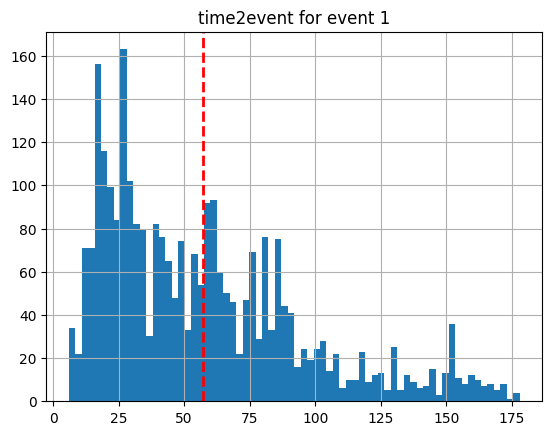

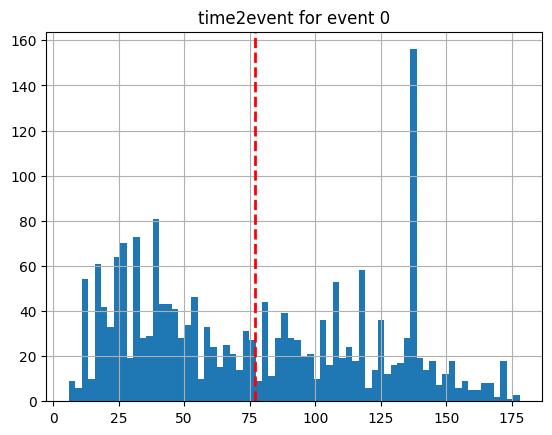

sold properties
count    2827.000000
mean       57.208702
std        38.290712
min         6.000000
25%        26.000000
50%        48.000000
75%        80.000000
max       178.000000
Name: time2event, dtype: float64
unsold properties
count    1913.000000
mean       76.857815
std        45.334481
min         6.000000
25%        36.000000
50%        73.000000
75%       118.000000
max       178.000000
Name: time2event, dtype: float64


In [99]:
# prompt: plot two histograms, one for the time2event column for rows with event == 1 and one for event==0

model_df2[model_df2['event']==1]['time2event'].hist(bins=70)
plt.title('time2event for event 1')
plt.axvline(model_df2[model_df2['event']==1]['time2event'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
model_df2[model_df2['event']==0]['time2event'].hist(bins=70)
plt.title('time2event for event 0')
plt.axvline(model_df2[model_df2['event']==0]['time2event'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
print("sold properties")
print(model_df2[model_df2['event']==1]['time2event'].describe())
print("unsold properties")
print(model_df2[model_df2['event']==0]['time2event'].describe())

Vemos un comportamiento mas esparzo en las propiedades no vendidas así como una media más alta.

Diferencia de medias 19.649113 días.

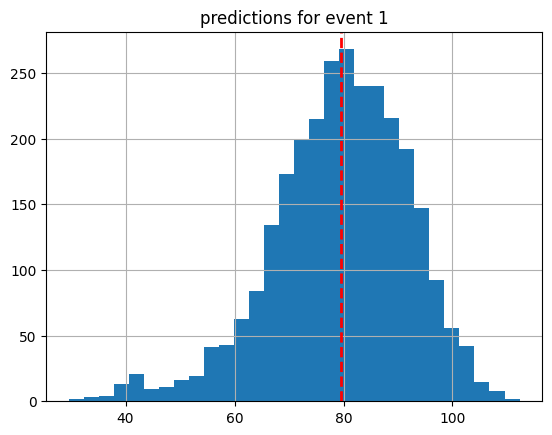

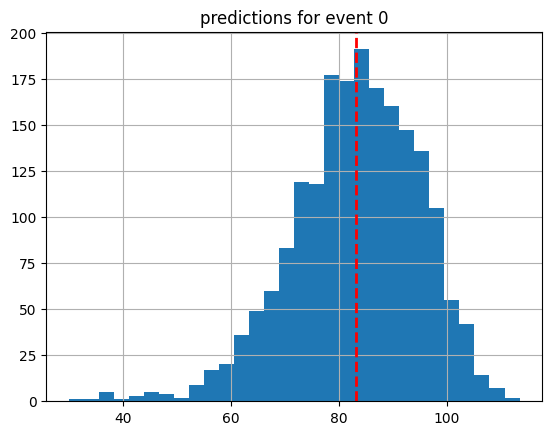

sold properties
count    2827.000000
mean       79.449340
std        12.493171
min        29.554056
25%        71.932367
50%        80.292089
75%        88.222968
max       112.311085
Name: preds, dtype: float64
unsold properties
count    1913.000000
mean       83.217781
std        11.793947
min        30.018968
25%        75.868128
50%        83.935405
75%        91.786698
max       113.450223
Name: preds, dtype: float64


In [100]:
model_df2[model_df2['event']==1]['preds'].hist(bins=30)
plt.title('predictions for event 1')
plt.axvline(model_df2[model_df2['event']==1]['preds'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
model_df2[model_df2['event']==0]['preds'].hist(bins=30)
plt.title('predictions for event 0')
plt.axvline(model_df2[model_df2['event']==0]['preds'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
print("sold properties")
print(model_df2[model_df2['event']==1]['preds'].describe())
print("unsold properties")
print(model_df2[model_df2['event']==0]['preds'].describe())

Aqui vemos dos distribuciones más similares. La métrica muestra poco eficiente para predecir valores extremos pero mantiene las tendencias generales.


Diferencia de medias: 3.768441 días

Observando el comportamiento de venta de las vendidas vs las no-vendidas en eventos realizados y en predicciones

median for unsold 73.0
median for sold 48.0


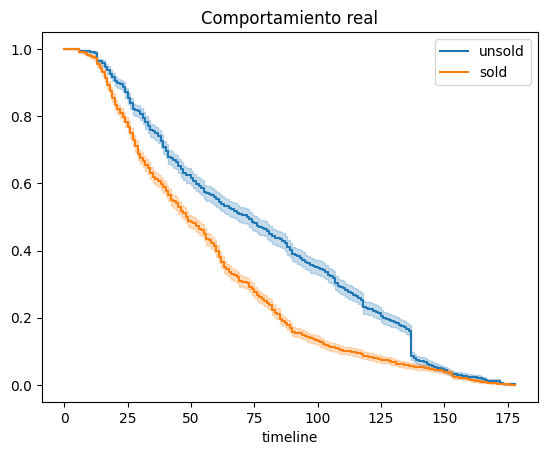

In [104]:
for i in [0,1]:
  kmf.fit(model_df2[model_df2['event']==i]['time2event'], label=i*"sold"+(1-i)*"unsold")
  kmf.plot_survival_function()
  print("median for "+i*"sold"+(1-i)*"unsold",kmf.median_survival_time_)

plt.title("Comportamiento real")
plt.show()

median for unsold 83.93540476860682
median for sold 80.29208921985963


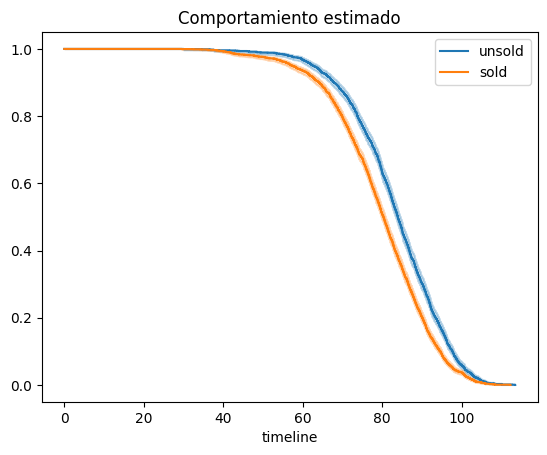

In [105]:
for i in [0,1]:
  kmf.fit(model_df2[model_df2['event']==i]['preds'], label=i*"sold"+(1-i)*"unsold")
  kmf.plot_survival_function()
  print("median for "+i*"sold"+(1-i)*"unsold",kmf.median_survival_time_)

plt.title("Comportamiento estimado")
plt.show()

In [106]:
model_df2["err"] = (model_df2["preds"]-model_df2["time2event"])

Errores

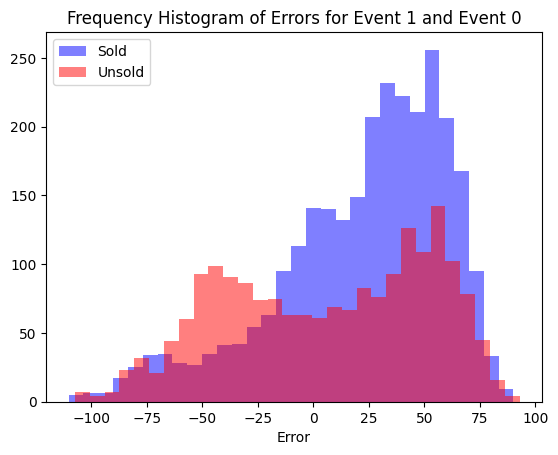

In [112]:
# Filter the DataFrame for event=1 and event=0
event_1_data = model_df2[model_df2['event'] == 1]['err']
event_0_data = model_df2[model_df2['event'] == 0]['err']

# Set the number of bins for the histogram
bins = 30

# Create the histograms
plt.hist(event_1_data, bins=bins, alpha=0.5, label='Sold', color='blue')
plt.hist(event_0_data, bins=bins, alpha=0.5, label='Unsold', color='red')

# Add labels and a legend
plt.xlabel('Error')
plt.ylabel('')
plt.title('Frequency Histogram of Errors for Event 1 and Event 0')
plt.legend()

# Show the plot
plt.show()


Vemos que el modelo predice con menos presición a las propiedades no vendidas, aunque el error parece centrarce en 0.
Por el otro lado, se ve que el modelo sobre estima el tiempo de venta de las propiedades en el csv ya vendidas.

In [114]:
print(model_df2[model_df2['event']==1]['err'].describe())
print(model_df2[model_df2['event']==0]['err'].describe())

count    2827.000000
mean       22.240638
std        38.392440
min      -110.107098
25%         0.870727
50%        30.565351
75%        51.851324
max        90.104470
Name: err, dtype: float64
count    1913.000000
mean        6.359966
std        45.740637
min      -107.241457
25%       -33.977247
50%        11.372089
75%        46.986286
max        92.830905
Name: err, dtype: float64


Estratificación manual

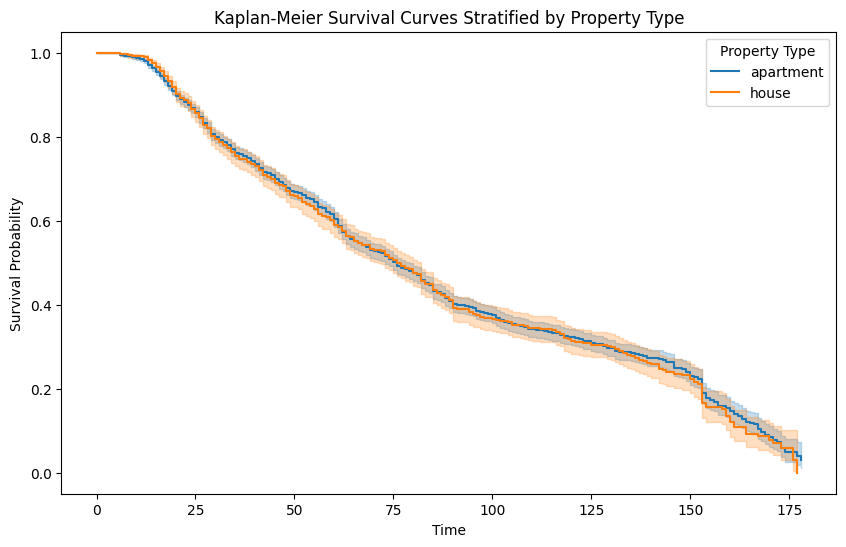

In [116]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
data=df
# Plotting the survival function for each property type
plt.figure(figsize=(10, 6))
for property_type in data['property_type'].unique():
    # Select data for each property type
    idx = data['property_type'] == property_type
    kmf.fit(data[idx]['time2event'], event_observed=data[idx]['event'], label=property_type)
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves Stratified by Property Type')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Property Type')
plt.show()




median for 2 73.0
median for 1 65.0
median for 3 76.0
median for 4 90.0


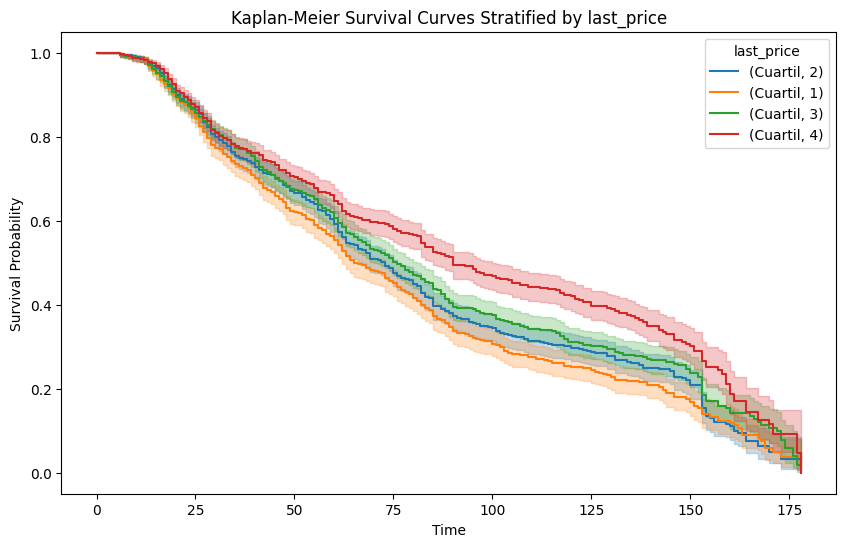

In [121]:
df = data
# Calculate the percentiles
percentiles = df['last_price'].quantile([0.25, 0.5, 0.75])

# Function to map percentiles to values 1, 2, 3, or 4
def map_percentile_to_value(last_price):
    if last_price <= percentiles[0.25]:
        return 1
    elif last_price <= percentiles[0.5]:
        return 2
    elif last_price <= percentiles[0.75]:
        return 3
    else:
        return 4

# Add a new column "percentile_column"
df['percentile_column'] = df['last_price'].apply(map_percentile_to_value)
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plotting the survival function for each property type
plt.figure(figsize=(10, 6))
for percentile_column in df['percentile_column'].unique():
    # Select df for each property type
    idx = df['percentile_column'] == percentile_column
    kmf.fit(df[idx]['time2event'], event_observed=df[idx]['event'], label=("Cuartil",percentile_column))
    kmf.plot_survival_function()
    print("median for "+str(percentile_column),kmf.median_survival_time_)

plt.title('Kaplan-Meier Survival Curves Stratified by last_price')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='last_price')
plt.show()

median for 1 66.0
median for 2 89.0


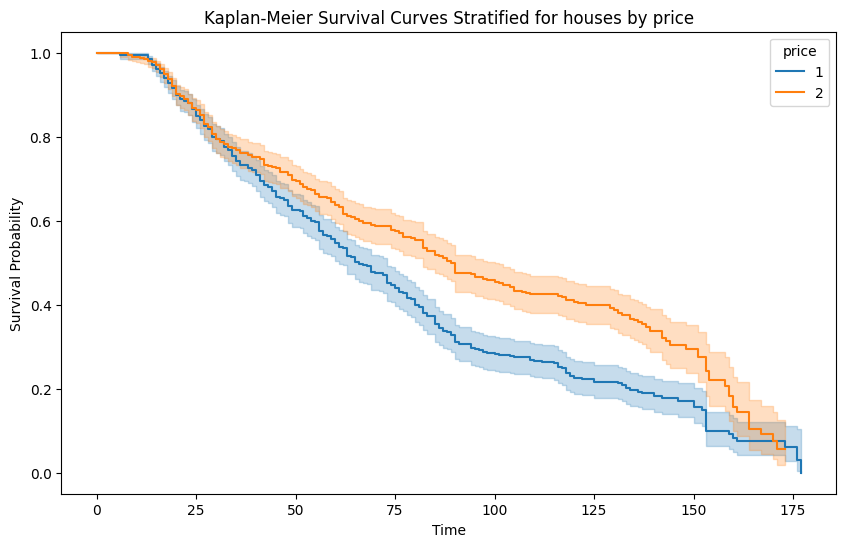

In [123]:
# Initialize the Kaplan-Meier fitter
df = data
# Calculate the percentiles for 'last_price' within the subset of 'house' property_type
house_data = df[df['property_type'] == 'house'].copy()
percentiles = house_data['last_price'].quantile([0.25, 0.50, 0.75])

# Function to map percentiles to values 1 or 2
def map_percentile_to_value(last_price):
    #if last_price <= percentiles[0.25]:
        #return 1
    if last_price <= percentiles[0.50]:
        return 1
    #elif last_price <= percentiles[0.75]:
      #return 3
    else:
        return 2

# Apply the mapping function to create the 'percentile_column' for 'house' rows
house_data['percentile_column'] = house_data['last_price'].apply(map_percentile_to_value)
kmf = KaplanMeierFitter()

# Plotting the survival function for each property type
plt.figure(figsize=(10, 6))
for percentile_column in house_data['percentile_column'].unique():
    # Select house_data for each property type
    idx = house_data['percentile_column'] == percentile_column
    kmf.fit(house_data[idx]['time2event'], event_observed=house_data[idx]['event'], label=str(percentile_column))
    kmf.plot_survival_function()
    print("median for "+str(percentile_column),kmf.median_survival_time_)

plt.title('Kaplan-Meier Survival Curves Stratified for houses by price')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='price')
plt.show()

median for 1 69.0
median for 2 83.0


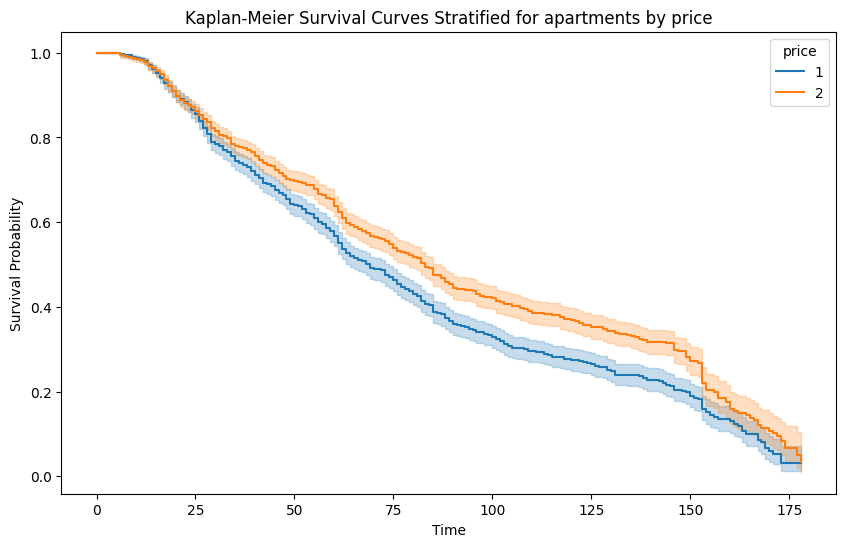

In [124]:
# Initialize the Kaplan-Meier fitter
df = data
# Calculate the percentiles for 'last_price' within the subset of 'house' property_type
house_data = df[df['property_type'] == 'apartment'].copy()
percentiles = house_data['last_price'].quantile([0.25, 0.50, 0.75])

# Function to map percentiles to values 1 or 2
def map_percentile_to_value(last_price):
    #if last_price <= percentiles[0.25]:
        #return 1
    if last_price <= percentiles[0.50]:
        return 1
    #elif last_price <= percentiles[0.75]:
      #return 3
    else:
        return 2

# Apply the mapping function to create the 'percentile_column' for 'house' rows
house_data['percentile_column'] = house_data['last_price'].apply(map_percentile_to_value)
kmf = KaplanMeierFitter()

# Plotting the survival function for each property type
plt.figure(figsize=(10, 6))
for percentile_column in house_data['percentile_column'].unique():
    # Select house_data for each property type
    idx = house_data['percentile_column'] == percentile_column
    kmf.fit(house_data[idx]['time2event'], event_observed=house_data[idx]['event'], label=str(percentile_column))
    kmf.plot_survival_function()
    print("median for "+str(percentile_column),kmf.median_survival_time_)

plt.title('Kaplan-Meier Survival Curves Stratified for apartments by price')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='price')
plt.show()

Al separar los typos de propiedad y despues separar en caros y baratos, podemos ver un comportamiento claramente distinto.

median for 2.0 73.0
median for 1.0 79.0
median for 3.0 77.0
median for 4.0 78.0
median for 6.0 62.0
median for 5.0 98.0
median for 0.0 77.0


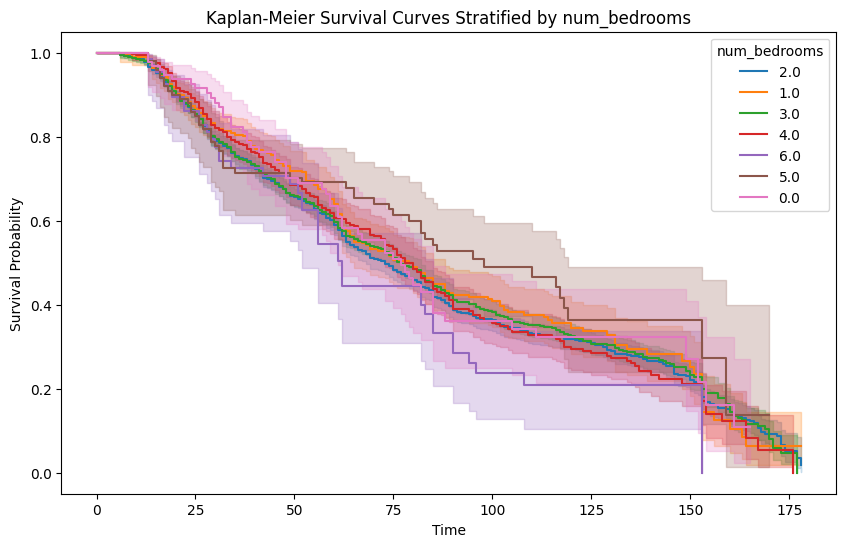

In [125]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plotting the survival function for each property type
plt.figure(figsize=(10, 6))
for num_bedrooms in data['num_bedrooms'].unique():
    # Select data for each property type
    idx = data['num_bedrooms'] == num_bedrooms
    kmf.fit(data[idx]['time2event'], event_observed=data[idx]['event'], label=num_bedrooms)
    kmf.plot_survival_function()
    print("median for "+str(num_bedrooms),kmf.median_survival_time_)

plt.title('Kaplan-Meier Survival Curves Stratified by num_bedrooms')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='num_bedrooms')
plt.show()


## Modelos descartados

consideracion a futuro: con un dataset más grande, el Random Survival Forest debería outperformear al CPH

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['time2event'],axis=1), dff['time2event'], test_size=0.25)
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.07234111691607492

In [25]:
dff_RFC = dff.copy()
dff_RFC["preds"] = clf.predict(dff.drop(['time2event'],axis=1))

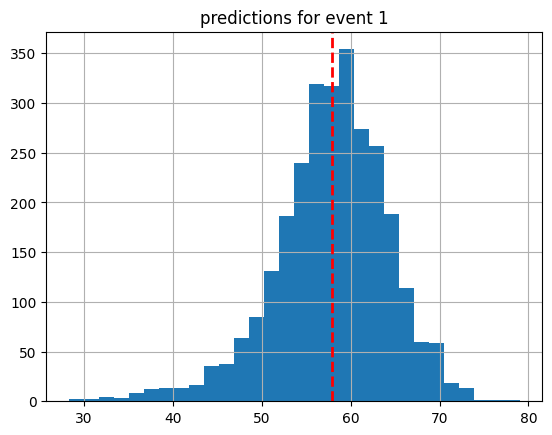

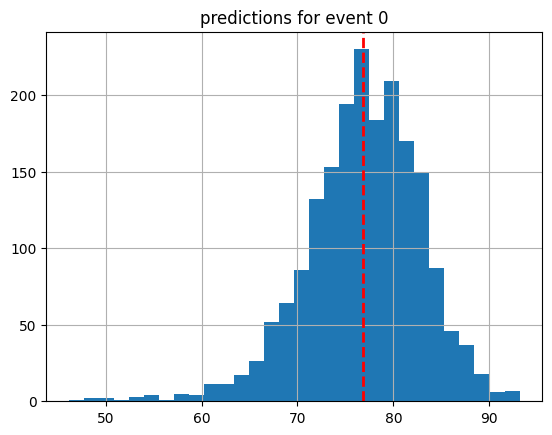

sold properties
count    2827.000000
mean       57.875300
std         6.396994
min        28.279886
25%        54.338149
50%        58.317494
75%        62.130537
max        78.997125
Name: preds, dtype: float64
unsold properties
count    1913.000000
mean       76.885654
std         6.067791
min        46.134787
25%        73.515244
50%        77.265858
75%        81.006575
max        93.160892
Name: preds, dtype: float64


In [26]:
dff_RFC[dff_RFC['event']==1]['preds'].hist(bins=30)
plt.title('predictions for event 1')
plt.axvline(dff_RFC[dff_RFC['event']==1]['preds'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
dff_RFC[dff_RFC['event']==0]['preds'].hist(bins=30)
plt.title('predictions for event 0')
plt.axvline(dff_RFC[dff_RFC['event']==0]['preds'].mean(), color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.show()
print("sold properties")
print(dff_RFC[dff_RFC['event']==1]['preds'].describe())
print("unsold properties")
print(dff_RFC[dff_RFC['event']==0]['preds'].describe())

In [27]:
dff_RFC["err"] = (dff_RFC["preds"]-model_df2["time2event"])**2

In [28]:
dff_RFC["err"].describe()

count     4740.000000
mean      1668.260716
std       2079.943121
min          0.000887
25%        283.962016
50%       1020.265515
75%       2174.892363
max      14817.380166
Name: err, dtype: float64

<Axes: >

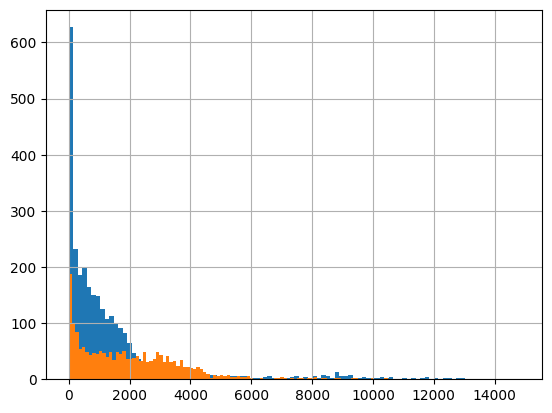

In [29]:
dff_RFC[dff_RFC['event']==1]['err'].hist(bins=100)
dff_RFC[dff_RFC['event']==0]['err'].hist(bins=100)

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [31]:
bm = dff.copy()

In [32]:
# Assuming bm is your DataFrame with 'time2event' as the target and other features
X = bm.drop('time2event', axis=1)
y = bm['time2event']

# Splitting the data
# Assuming bm is your DataFrame
# Separate the data into two parts
event_1_df = bm[bm['event'] == 1]
event_not_1_df = bm[bm['event'] != 1]

# Split the event_1 data into training and test sets (20% in test set)
X_event_1 = event_1_df.drop('time2event', axis=1)
y_event_1 = event_1_df['time2event']

X_event_1_train, X_test, y_train, y_test = train_test_split(
    X_event_1, y_event_1, test_size=0.2, random_state=42)

# Combine the training part of event_1 data with the event_not_1 data
X_train = pd.concat([X_event_1_train, event_not_1_df.drop('time2event', axis=1)])
y_train = pd.concat([y_train, event_not_1_df['time2event']])

# Cox Proportional Hazards model
cox_model = CoxPHFitter()
cox_model.fit(bm, duration_col='time2event', event_col='event')  # assuming 'event' column indicates the sale event

# Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
cox_predictions = cox_model.predict_median(X_test)
rf_predictions = rf_model.predict(X_test)

# Evaluation
cox_error = mean_squared_error(y_test, cox_predictions, squared=False)
rf_error = mean_squared_error(y_test, rf_predictions, squared=False)

print(f"Cox Model RMSE: {cox_error}")
print(f"Random Forest RMSE: {rf_error}")

Cox Model RMSE: 43.4042547294837
Random Forest RMSE: 39.30538980016797


In [33]:
pip install scikit-survival

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sksurv.ensemble import RandomSurvivalForest

In [35]:
bm.keys()

Index(['event', 'time2event', 'num_bathrooms', 'num_bedrooms',
       'num_parking_lots', 'views', 'num_marketplaces_property_at',
       'has_balcony', 'has_gym', 'has_luxury_features', 'has_studio',
       'has_surveillance', 'has_terrace', 'log_price', 'property_type_house'],
      dtype='object')

In [36]:
Xt = bm.drop(['time2event','event'], axis=1)
y = bm[['event','time2event']]

In [37]:
Xt.keys()

Index(['num_bathrooms', 'num_bedrooms', 'num_parking_lots', 'views',
       'num_marketplaces_property_at', 'has_balcony', 'has_gym',
       'has_luxury_features', 'has_studio', 'has_surveillance', 'has_terrace',
       'log_price', 'property_type_house'],
      dtype='object')

In [38]:
random_state = 20

X_train, X_test, y_train1, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [43]:
y_train = np.array(
    [(row['event'], row['time2event']) for index, row in y_train1.iterrows()],
    dtype=[('event', 'bool'), ('time2event', 'float')])

In [40]:
rsf = RandomSurvivalForest(
    n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [56]:
X_test_pred = X_test.copy()
X_test_pred["preds"] = rsf.predict(X_test)

In [57]:
X_test_pred.head()

,num_bathrooms,num_bedrooms,num_parking_lots,views,num_marketplaces_property_at,has_balcony,has_gym,has_luxury_features,has_studio,has_surveillance,has_terrace,log_price,property_type_house,preds
354,2.0,2.0,0.0,68,2,0,1,0,0,1,1,15.623799,0,150.926769
3922,3.0,3.0,2.0,53,3,1,0,0,0,1,1,16.001562,0,123.401675
3358,4.0,4.0,2.0,57,6,1,0,0,0,1,0,16.642824,0,125.166742
1294,2.0,4.0,2.0,99,3,0,0,0,0,0,1,15.732433,1,159.632415
3883,2.0,2.0,1.0,79,3,1,0,0,0,0,0,15.068274,0,162.739870


In [77]:
yy = pd.DataFrame(y_test, columns=["time2event","event"])
yy["time2event"].describe()

count    1185.000000
mean       65.816878
std        42.938254
min         6.000000
25%        29.000000
50%        55.000000
75%        93.000000
max       178.000000
Name: time2event, dtype: float64

In [79]:
yy = yy.reset_index(drop=True)
X_test_pred = X_test_pred.reset_index(drop=True)
X_test_pred["time2event"] = yy["time2event"]

In [82]:
X_test_pred

,num_bathrooms,num_bedrooms,num_parking_lots,views,num_marketplaces_property_at,has_balcony,has_gym,has_luxury_features,has_studio,has_surveillance,has_terrace,log_price,property_type_house,preds,time2event
0,2.0,2.0,0.0,68,2,0,1,0,0,1,1,15.623799,0,150.926769,152.0
1,3.0,3.0,2.0,53,3,1,0,0,0,1,1,16.001562,0,123.401675,28.0
2,4.0,4.0,2.0,57,6,1,0,0,0,1,0,16.642824,0,125.166742,76.0
3,2.0,4.0,2.0,99,3,0,0,0,0,0,1,15.732433,1,159.632415,78.0
4,2.0,2.0,1.0,79,3,1,0,0,0,0,0,15.068274,0,162.739870,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,4.0,3.0,2.0,65,3,0,0,0,0,0,1,14.797589,1,165.041334,34.0
1181,2.0,2.0,2.0,59,4,0,1,0,0,1,1,15.656060,0,177.464598,128.0
1182,2.0,2.0,2.0,0,2,0,1,0,0,1,0,15.341567,0,146.833509,173.0
1183,2.5,3.0,2.0,34,1,0,0,0,0,1,0,15.702580,1,118.925534,116.0


<Axes: >

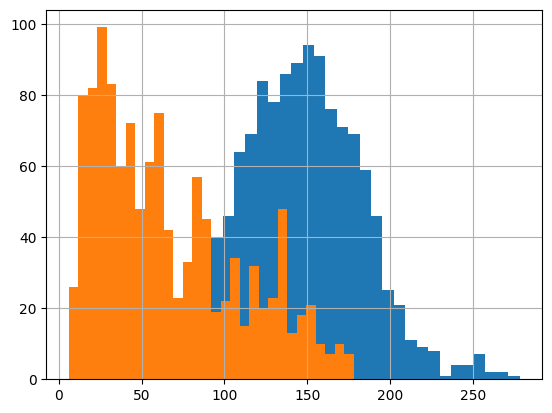

In [81]:
X_test_pred["preds"].hist(bins=30)
X_test_pred["time2event"].hist(bins=30)

In [42]:
y_test = np.array(
    [(row['event'], row['time2event']) for index, row in y_test.iterrows()],
    dtype=[('event', 'bool'), ('time2event', 'float')])

AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'

In [83]:
rsf.score(X_test, y_test)

0.5717014195027332